
# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives

At the end of the experiment you will be able to :

- understand how to implement keras neural networks on MFCC features

In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="850" height="480" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Walkthrough/Speech_emotion_recognition.mp4" type="video/mp4">
</video>
""")


## Dataset

### Description



In this experiment we will use Ryerson Audio-Visual Database of Emotional Speech and Song ([RAVDESS - Livingstone SR, Russo FA (2018)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391)) which includes 1432 voices of 24 professional actors (12 female, 12 male). Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention:** Each of the 1432 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

*Filename identifiers*
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*Filename example: 03-01-06-01-02-01-12.wav*
- Audio-only (03)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "Dogs are sitting by the door" (02)
- 1st Repetition (01)
- 12th Actor (12) -> Female, as the actor ID number is even.


## Domain Information

When we listen to an audio sample it changes constantly. This means that speech is non-stationary signal. Therefore, normal signal processing techniques cannot be applied to get features from audio. However, if the speech signal is observed using a very small duration window, the speech content in that small duration appears to be  stationary. That brought in the concept of short-time processing of speech. 

MFCC is a technique for short-time processing of speech. 


In [ ]:
! wget -qq https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/ravdess.zip
! unzip ravdess.zip

### Importing required packages


In [ ]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

## Data Exploration and Visualization

Data Exploration and Visualization helps us to understand the data

### Visualization of a sample audio signal in time series domain

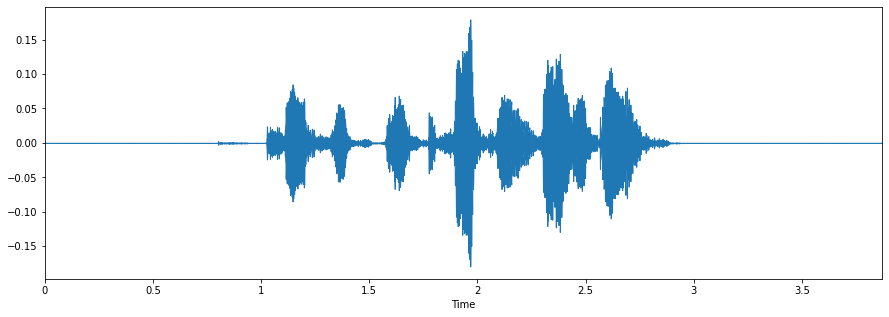

In [ ]:
train_audio_path = 'ravdess/data'

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(train_audio_path+'/angry/03-01-05-01-01-01-01.wav')
plt.figure(figsize=(15, 5))

#librosa.display.waveplot is used to plot waveform of amplitude vs time
librosa.display.waveplot(data, sr=sampling_rate)
plt.show()

**Playing an audio**

In [ ]:
ipd.Audio(data, rate=sampling_rate)

### Visualize the number of recordings for each emotion

In [ ]:
labels = os.listdir(train_audio_path)
print(labels)

['calm', 'angry', 'neutral', 'surprised', 'happy', 'fearful', 'disgust', 'sad']


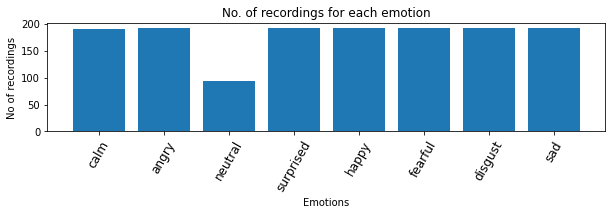

In [ ]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#bar plot
plt.figure(figsize=(10,2))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Emotions', fontsize=10)
plt.ylabel('No of recordings', fontsize=10)
plt.xticks(index, labels, fontsize=12, rotation=60)
plt.title('No. of recordings for each emotion')
plt.show()

### Vizualize the distribution of the duration of recordings

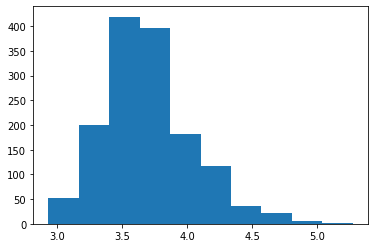

In [ ]:
import wavio

duration_of_recordings = []

for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]   
    for wav in waves:
        wav = wavio.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(wav.data)/wav.rate))

plt.hist(np.array(duration_of_recordings))
plt.show()

## Feature Extraction

Create Mel Frequency Cepstral Coefficient features which represents the short-term power spectrum of a sound and Labels dataset

In [ ]:
def extract_feature(file_name):
      X, sample_rate = librosa.load(file_name)
      feature = np.array([])
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
      features = np.hstack((feature, mfccs))
      return features

In [ ]:
# The below process is going to take some time
all_wave = []
all_label = []

for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        file_path = train_audio_path + '/' + label + '/' + wav
        features = extract_feature(file_path)
        all_wave.append(features)
        all_label.append(label)

# Reshape the 2D array to 3D since the input to the conv1d must be a 3D array
all_wave = np.array(all_wave).reshape(-1, 40, 1)
print("Shape of the features: ", all_wave.shape)

calm
angry
neutral
surprised
happy
fearful
disgust
sad
Shape of the features:  (1432, 40, 1)


Convert the output labels to integer encoded

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

Convert the integer encoded labels to a one-hot vector since it is a multi-classification problem

In [ ]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels)) 

## Define and Train Model

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 80% of the train data and 20% of the validate data
x_train, x_val, y_train, y_val = train_test_split(all_wave, y, test_size = 0.2, shuffle=True)

### Implement the model using Keras functional API.

In [ ]:
import keras
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model

model = keras.Sequential()
model.add(Conv1D(64, kernel_size=(9), activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(128, kernel_size=(9), activation='relu'))
model.add(MaxPooling1D(pool_size=(7)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 32, 64)            640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 128)           73856     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
# Define the loss function to be categorical cross-entropy since it is a multi-classification problem
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and evaluate the performance on the validation set
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
36/36 [==============================] - 32s 12ms/step - loss: 2.9165 - accuracy: 0.1651 - val_loss: 1.9705 - val_accuracy: 0.2230
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 1.9830 - accuracy: 0.2044 - val_loss: 1.8737 - val_accuracy: 0.3101
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 1.9565 - accuracy: 0.2140 - val_loss: 1.8509 - val_accuracy: 0.2997
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 1.9024 - accuracy: 0.2699 - val_loss: 1.8191 - val_accuracy: 0.3763
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 1.8772 - accuracy: 0.2716 - val_loss: 1.7766 - val_accuracy: 0.3624
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 1.8311 - accuracy: 0.2961 - val_loss: 1.7195 - val_accuracy: 0.4007
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 1.7793 - accuracy: 0.3328 - val_loss: 1.6934 - val_accuracy: 0.4669
Epoch 8/50
36/36 [

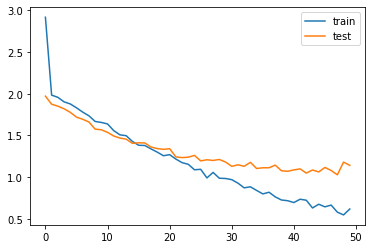

In [ ]:
# Vizualize the performance of the model over a period of time
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate the Model

Make predictions on the provided test samples

In [ ]:
# The below function predicts emotion for the given audio
def predict(audio):
    prob=model.predict(audio.reshape(1,40,1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
test_sample1 = "ravdess/angry_test_sample.wav"
data, sampling_rate = librosa.load(test_sample1)
prediction = predict(extract_feature(test_sample1))
print("Model Prediction: ", prediction)
ipd.Audio(data, rate = sampling_rate)

Model Prediction:  angry


In [ ]:
test_sample2 = "ravdess/happy_test_sample.wav"
data, sampling_rate = librosa.load(test_sample2)
prediction = predict(extract_feature(test_sample2))
print("Model Prediction: ", prediction)
ipd.Audio(data, rate = sampling_rate)

Model Prediction:  happy


In [ ]:
test_sample3 = "ravdess/sad_test_sample.wav"
data, sampling_rate = librosa.load(test_sample3)
prediction = predict(extract_feature(test_sample3))
print("Model Prediction: ", prediction)
ipd.Audio(data, rate = sampling_rate)

Model Prediction:  sad
